# Análise Exploratória da base REDD

Neste documento será realizada a Análise Exploratória de Dados (EDA) da base REDD utilizando a biblioteca NILMTK.

## Base REDD

Convertendo os dados originais da base [REDD](http://redd.csail.mit.edu) em arquivo compatível (hdf5, contendo medições e metadata) com a NILMTK. Vale ressaltar que será considerado neste documento apenas as leituras de baixa frequência.

In [1]:
from nilmtk.dataset_converters import convert_redd
convert_redd('datasets/REDD/low_freq', 'datasets/REDD/low_freq.h5')

Loading house 1... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 2... 1 2 3 4 5 6 7 8 9 10 11 
Loading house 3... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Loading house 4... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 5... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Loading house 6... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting REDD to HDF5!


## Carregando os dados via NILMTK

In [2]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

redd = DataSet('datasets/REDD/low_freq.h5')

### Explorando o objeto de dados  `REDD`

Primeiramente, é possível acessar os metadados do dataset, incluindo as informações sobre os dois modelos de medidores utilizados para a coleta dos dados:

In [3]:
print_dict(redd.metadata)

É possível também acessar informações das residências em um objeto do tipo [OrderedDict](https://docs.python.org/2/library/collections.html#collections.OrderedDict) (indexado a partir de 1 porque todo dataset no NILMTK inicia o índice de `buildings`em 1 e não 0)

In [4]:
print_dict(redd.buildings)

Cara residência possui algumas informações de metadata:

In [5]:
print_dict(redd.buildings[1].metadata)

Ainda, cada residência possui um atributo `elec` que é o objeto `MeterGroup` (de fato, os medidores do tipo `plug`utilizado na mediçção de cada um dos dispositivos contemplados):

In [7]:
redd.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

Note que há dois objetos `MeterGroups` aninhados: um para o forno elétrico, e um para a secadora (ambos são dispositivos de 240 vol e possuem dois medidores por aparelho, dada a voltagem dos mesmos):

In [9]:
elec = redd.buildings[1].elec
elec.nested_metergroups()

[MeterGroup(meters=
   ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
   ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
 ), MeterGroup(meters=
   ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
   ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
 )]

Colocar estes medidores em um objeto do tipo `MeterGroup` permite facilmente somar a demanda de energia registrada por ambos os medidores a fim de capturar a demanda total de energia para o dispositivo (mas é também muito fácil ver a demanda de energia individual registrada).

É fácil acessar um `MeterGroup` de submedidores (medição no nível de dispositivos) ou da(s) corrente(s) principais (mains):

In [10]:
elec.mains()

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

Neste caso, é possível capturar os dados de energia de ambas as correntes principais somadas:

In [11]:
elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


2011-04-18 09:22:09-04:00    342.820007
2011-04-18 09:22:10-04:00    344.559998
2011-04-18 09:22:11-04:00    345.140015
2011-04-18 09:22:12-04:00    341.679993
2011-04-18 09:22:13-04:00    341.029999
Name: (power, apparent), dtype: float32

No caso das medições individuais dos dispositivos:

In [13]:
elec.submeters()

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(insta

## Estatísticas para os `MeterGroups`

### Proporção de energia submedida

Vamos verificar a proporção de energia submedida na residência 1:

In [15]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...
Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='REDD') ...   

0.7599031850888346

### Potência ativa, reativa e aparente

Vamos verificar os tipos de medida de energia que foram usadas para as medições (correntes principais e dispositivos):

In [17]:
mains = elec.mains() # Correntes principais
mains.available_ac_types('power')

['apparent']

In [18]:
elec.submeters().available_ac_types('power') # Dispositivos

['active']

In [19]:
next(elec.load()) # Verificando os dispositivos

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=4, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=20, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.

Done loading data all meters for this chunk.


physical_quantity          power            
type                      active    apparent
2011-04-18 09:22:09-04:00    NaN  344.173340
2011-04-18 09:22:12-04:00  261.0  341.170013
2011-04-18 09:22:15-04:00  261.0  341.973328
2011-04-18 09:22:18-04:00  262.0  341.683319
2011-04-18 09:22:21-04:00  262.0  341.796661
2011-04-18 09:22:24-04:00  261.0  341.330017
2011-04-18 09:22:27-04:00  261.0  341.223328
2011-04-18 09:22:30-04:00  260.0  341.250000
2011-04-18 09:22:33-04:00  260.0  341.503326
2011-04-18 09:22:36-04:00  262.0  342.196655
2011-04-18 09:22:39-04:00  266.0  345.356689
2011-04-18 09:22:42-04:00  260.0  342.736664
2011-04-18 09:22:45-04:00  261.0  342.610016
2011-04-18 09:22:48-04:00  261.0  342.683350
2011-04-18 09:22:51-04:00  267.0  344.553345
2011-04-18 09:22:54-04:00  262.0  341.613342
2011-04-18 09:22:57-04:00  264.0  344.770020
2011-04-18 09:23:00-04:00  267.0  345.350006
2011-04-18 09:23:03-04:00  266.0  344.976654
2011-04-18 09:23:06-04:00  260.0  343.896667
2011-04-18 09:23:09-04:00  260.0  344.713318
2011-04-18 09:23:12-04:00  260.0  344.549988
2011-04-18 09:23:15-04:00  260.0  345.026672
2011-04-18 09:23:18-04:00  260.0  345.353333
2011-04-18 09:23:21-04:00  264.0  344.380005
2011-04-18 09:23:24-04:00  264.0  345.903320
2011-04-18 09:23:27-04:00  263.0  344.033325
2011-04-18 09:23:30-04:00  263.0  346.293335
2011-04-18 09:23:33-04:00  266.0  345.863342
2011-04-18 09:23:36-04:00  267.0  345.149994
...                          ...         ...
2011-05-24 15:55:33-04:00  246.0  274.713348
2011-05-24 15:55:36-04:00  247.0  277.260010
2011-05-24 15:55:39-04:00  247.0  276.209991
2011-05-24 15:55:42-04:00  240.0  274.000000
2011-05-24 15:55:45-04:00  240.0  274.250000
2011-05-24 15:55:48-04:00  244.0  275.653320
2011-05-24 15:55:51-04:00  246.0  277.756653
2011-05-24 15:55:54-04:00  242.0  275.173340
2011-05-24 15:55:57-04:00  240.0  274.473328
2011-05-24 15:56:00-04:00  240.0  273.679993
2011-05-24 15:56:03-04:00  243.0  272.766663
2011-05-24 15:56:06-04:00  241.0  273.660004
2011-05-24 15:56:09-04:00  242.0  273.729980
2011-05-24 15:56:12-04:00  245.0  273.609985
2011-05-24 15:56:15-04:00  243.0  273.743347
2011-05-24 15:56:18-04:00  242.0  274.056671
2011-05-24 15:56:21-04:00  240.0  273.526672
2011-05-24 15:56:24-04:00  240.0  274.350006
2011-05-24 15:56:27-04:00  243.0  274.796692
2011-05-24 15:56:30-04:00  242.0  274.220001
2011-05-24 15:56:33-04:00  241.0  273.739990
2011-05-24 15:56:36-04:00    NaN  274.326660
2011-05-24 15:56:39-04:00    NaN  275.693329
2011-05-24 15:56:42-04:00    NaN  273.793335
2011-05-24 15:56:45-04:00    NaN  273.366669
2011-05-24 15:56:48-04:00    NaN  273.266663
2011-05-24 15:56:51-04:00    NaN  274.496674
2011-05-24 15:56:54-04:00    NaN  273.959991
2011-05-24 15:56:57-04:00    NaN  273.636658
2011-05-24 15:57:00-04:00    NaN  273.825012

[1044698 rows x 2 columns]

### Energia Total da Residência 1

In [21]:
elec.mains().total_energy() # kWh

Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='REDD') ...   

apparent    167.766283
dtype: float64

### Energia Total por Submedidor (Dispositivos da Resid. 1)

In [22]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

(5, 1, REDD)  (6, 1, REDD)  (7, 1, REDD)  (8, 1, REDD)  \
active       44.750925     19.920875     16.786282     22.939649   
apparent           NaN           NaN           NaN           NaN   
reactive           NaN           NaN           NaN           NaN   

          (9, 1, REDD)  (11, 1, REDD)  (12, 1, REDD)  (13, 1, REDD)  \
active       30.734511      16.890262       5.221226       0.096302   
apparent           NaN            NaN            NaN            NaN   
reactive           NaN            NaN            NaN            NaN   

          (14, 1, REDD)  (15, 1, REDD)  (16, 1, REDD)  (17, 1, REDD)  \
active         0.411592       4.507334       2.256583      18.288595   
apparent            NaN            NaN            NaN            NaN   
reactive            NaN            NaN            NaN            NaN   

          (18, 1, REDD)  (19, 1, REDD)  (((3, 1, REDD), (4, 1, REDD)),)  \
active        11.811224       0.000085                          8.81796   
apparent            NaN            NaN                              NaN   
reactive            NaN            NaN                              NaN   

          (((10, 1, REDD), (20, 1, REDD)),)  
active                            32.614809  
apparent                                NaN  
reactive                                NaN

> NOTA: o cabeçalho se refere aos números de instância dos objetos `ElecMeter`.

### Selecione os medidores com base em seu consumo de energia

In [23]:
# energy_per_meter é um DataFrame onde cada linha é um 
# tipo de energia ('active', 'reactive' or 'apparent').
# Todos os medidores de dispositivo na base REDD registros 
# do tipo 'active', então basta selecionar a linha 'active':
energy_per_meter = energy_per_meter.loc['active']
more_than_20 = energy_per_meter[energy_per_meter > 20]
more_than_20

(5, 1, REDD)                         44.750925
(8, 1, REDD)                         22.939649
(9, 1, REDD)                         30.734511
(((10, 1, REDD), (20, 1, REDD)),)    32.614809
Name: active, dtype: float64

In [24]:
instances = more_than_20.index
instances

Index([                       (5, 1, 'REDD'),
                              (8, 1, 'REDD'),
                              (9, 1, 'REDD'),
       (((10, 1, 'REDD'), (20, 1, 'REDD')),)],
      dtype='object')

## Gráfico do Consumo de Energia de cada Dispositivo

In [31]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
rcParams['figure.figsize'] = (13, 10)

# Calculando proporção individual
fraction = elec.submeters().fraction_per_meter().dropna()

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=10, building=1, dataset='REDD') ...    total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

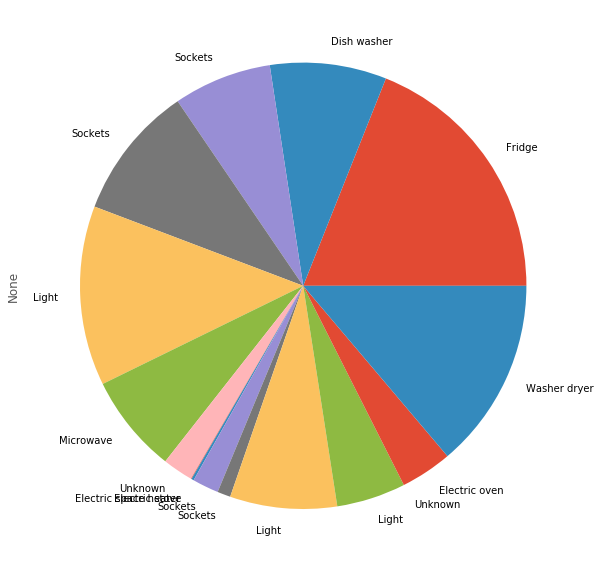

In [32]:
# Criando rótulos
labels = elec.get_labels(fraction.index)
# Plotando o gráfico
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

### Diagrama Wiring

(<networkx.classes.digraph.DiGraph at 0x18d4f8c2f60>,
 <matplotlib.axes._axes.Axes at 0x18d4f8cc160>)

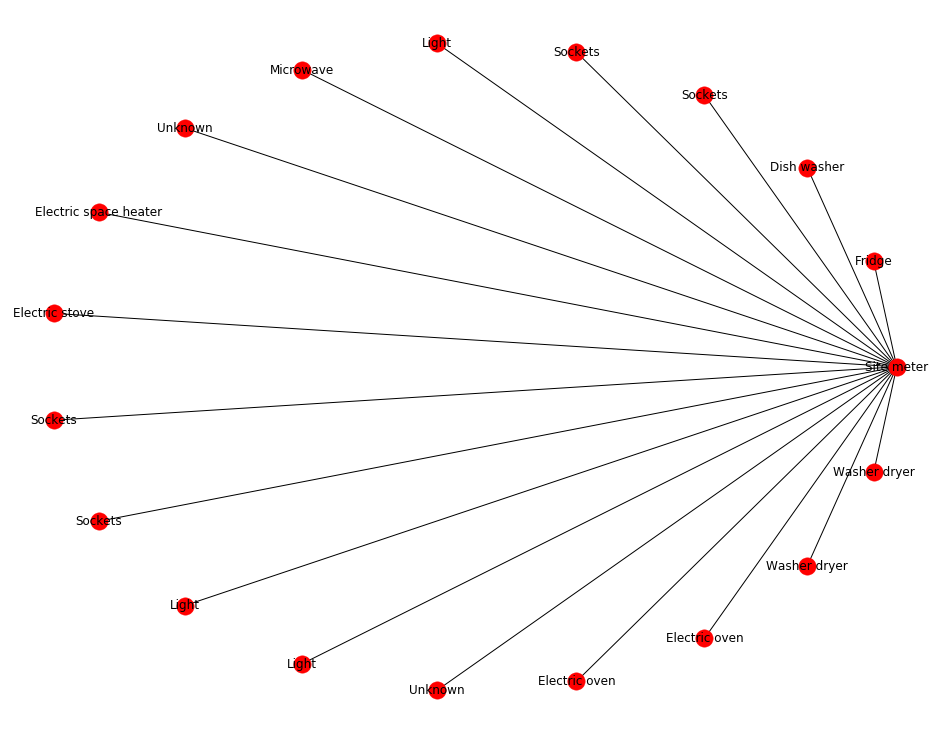

In [33]:
elec.draw_wiring_graph()

Não é muito evidente, mas este diagrama mostra que os medidores (1, 2 - medidores das plantas) estão a montante de todos os outros medidores.

> Residências da base REDD têm apenas dois níveis na sua 'hierarquia' de medidores (correntes principais - mains - e dispositivos individuais - submeters). Se houvessem mais que dois níveis, então seria útil obter apenas os medidores imediatamente a jusante de mains:

In [34]:
elec.meters_directly_downstream_of_mains()

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(insta

### Gráfico de Utilização dos Dispositivos

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


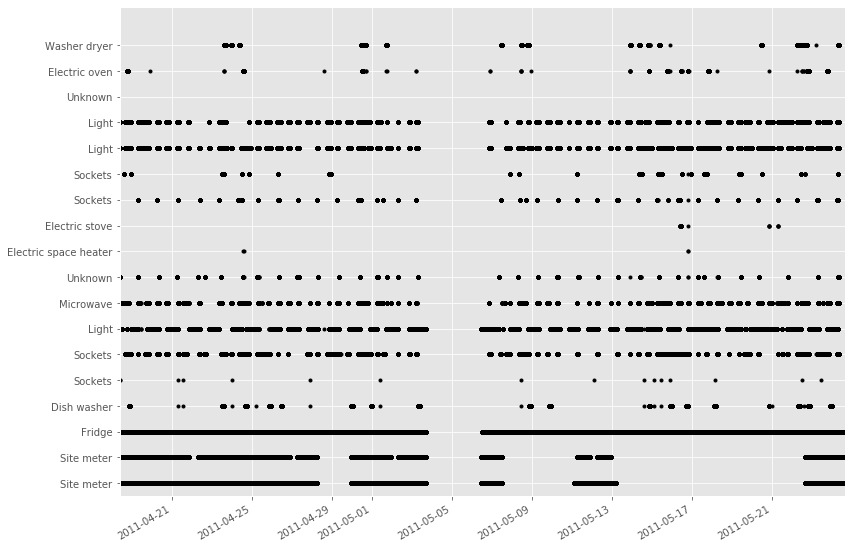

In [35]:
#sns.set_palette("Set3", n_colors=12)
# Set a threshold to remove residual power noise when devices are off
elec.plot_when_on(on_power_threshold = 40)

## Informações e Estatísticas Individuais dos Medidores

A classe `ElecMeter` represente um medidor de eletricidade único. 

Cada `ElecMeter` possui uma lista de objetos `Appliance` (dispositivos) associados.  

`ElecMeter` possui muitos dos mesmos métodos estatísticos do `MeterGroup` tais como `total_energy` e `available_power_ac_types` and `power_series` and `power_series_all_data`.  

Vamos explorar mais algumas funções estatísticas...

In [38]:
fridge_meter = elec['fridge'] # Dados de medição do forno elétrico

### Medidor Imediatamente Superiores

In [39]:
fridge_meter.upstream_meter()

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

### Metadata da Classe do Medidor

In [40]:
fridge_meter.device

{'model': 'eMonitor',
 'manufacturer': 'Powerhouse Dynamics',
 'manufacturer_url': 'http://powerhousedynamics.com',
 'description': 'Measures circuit-level power demand.  Comes with 24 CTs. This FAQ page suggests the eMonitor measures real (active) power: http://www.energycircle.com/node/14103  although the REDD readme.txt says all channels record apparent power.\n',
 'sample_period': 3,
 'max_sample_period': 50,
 'measurements': [{'physical_quantity': 'power',
   'type': 'active',
   'upper_limit': 5000,
   'lower_limit': 0}],
 'wireless': False}

### Energia Total Consumida (kWh)

In [41]:
fridge_meter.total_energy() # kWh

active    44.750925
dtype: float64

### Outras Informações

Se visualizarmos os dados de energia originais, poderemos observar que há um grande *gap* onde, supostamente, o medidor associado a este dispositivo parou de funcionar (vale ressaltar que, se aumentarmos o zoom, poderemos observar pequenos intervalos com este mesmo comportamento):

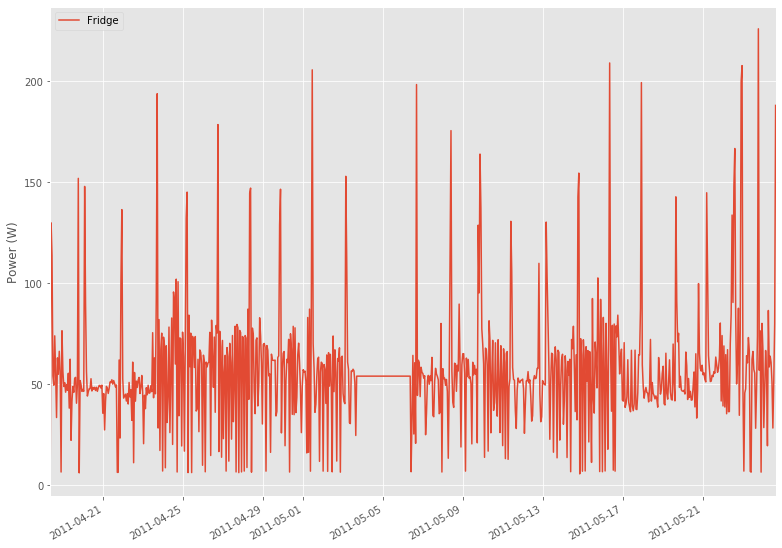

In [43]:
fridge_meter.plot()

Podemos automaticamente identificar 'good sections' (i.e. seções onde cada par de amostras consecutivas é menor que o valor de `max_sample_period` especificado no metadata do dataset):

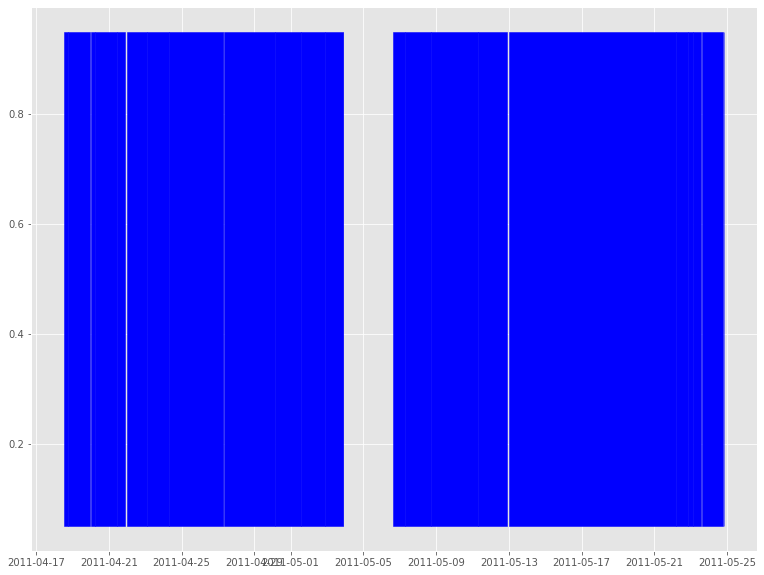

In [44]:
good_sections = fridge_meter.good_sections(full_results=True)
# full_results=False nos dá uma lista dimples de TimeFrames.  
# Mas queremos todos GoodSectionsResults para que seja possível plotar as 'good sections'...
good_sections.plot()

Os blocos mostram onde os dados são 'bons' (good). O *gap* branco é o largo intervalo em branco visto nos dados originais.

É possível também listar as 'good sections':

In [47]:
good_sections.combined()

[TimeFrame(start='2011-04-18 09:22:13-04:00', end='2011-04-18 14:00:33-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:03:11-04:00', end='2011-04-19 18:45:09-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:20:05-04:00', end='2011-04-20 01:54:26-04:00', empty=False),
 TimeFrame(start='2011-04-20 01:55:33-04:00', end='2011-04-21 06:14:43-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:17:22-04:00', end='2011-04-21 17:45:02-04:00', empty=False),
 TimeFrame(start='2011-04-21 19:41:23-04:00', end='2011-04-22 22:46:53-04:00', empty=False),
 TimeFrame(start='2011-04-22 22:48:31-04:00', end='2011-04-24 03:48:44-04:00', empty=False),
 TimeFrame(start='2011-04-24 03:52:28-04:00', end='2011-04-27 02:50:14-04:00', empty=False),
 TimeFrame(start='2011-04-27 02:51:25-04:00', end='2011-04-27 03:17:31-04:00', empty=False),
 TimeFrame(start='2011-04-27 03:21:19-04:00', end='2011-04-29 23:07:52-04:00', empty=False),
 TimeFrame(start='2011-04-29 23:10:38-04:00', end='2011-05-01 09:44:36

## Selecionando Subgrupos de Medidores

Usamos `ElecMeter.select_using_appliances()` para selecionar um novo MeterGroup usando um campo metadata.  
Por exemplo, para pegar todas as máquinas secadores no dataset REDD (considerenado todas residências), fasemos o seguinte:

In [48]:
import nilmtk
nilmtk.global_meter_group.select_using_appliances(type='washer dryer')

MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=7, building=4, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=8, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=9, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=4, building=6, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1

> Ou selecionamos múltiplos dispositivos pelo tipo:

In [50]:
elec.select_using_appliances(type=['fridge', 'microwave'])

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
)

> Ou então pela categoria dos dispositivos (por exemplo, os aquecedores):

In [51]:
nilmtk.global_meter_group.select_using_appliances(category='heating')

MeterGroup(meters=
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=10, building=3, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=4, building=4, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=6, building=5, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=12, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=13, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=12, building=6, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
)

## Selecionando um Único Dispositivo de um `MeterGroup`

Usamos o marcador `[]` para retornar um único dispositivo (objeto `ElecMeter`) de um `MeterGroup`.

In [53]:
elec['fridge']

ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

In [54]:
elec.select_using_appliances(type='fridge')

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
)

In [55]:
elec['light', 2]

ElecMeter(instance=17, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=2)])

## Gráfico de Consumo de Energia Individual

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


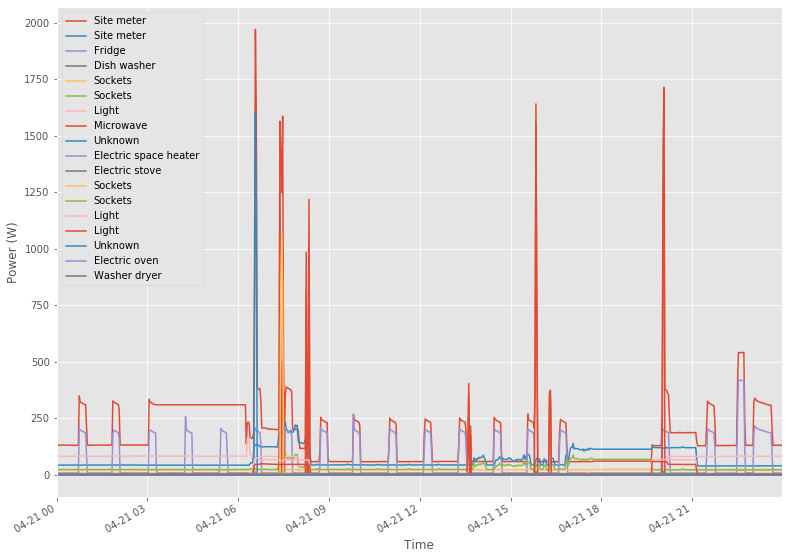

In [56]:
redd.set_window(start='2011-04-21', end='2011-04-22')
elec.plot();
plt.xlabel("Time");

## Gráfico de Autocorrelação

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


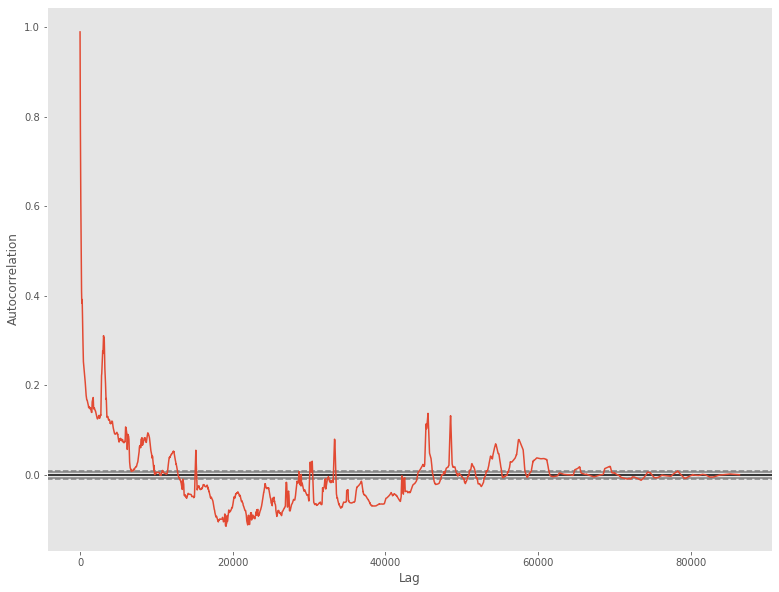

In [61]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

elec.mains().plot_autocorrelation() # Correntes principais

## Consumo de Energia Diário de um Conjunto de Dispositivos

Considerando dispositivos do tipo 'forno elétrico':

In [64]:
fridges_restricted = nilmtk.global_meter_group.select_using_appliances(type='fridge')
daily_energy = pd.Series([meter.average_energy_per_period(offset_alias='D') 
                          for meter in fridges_restricted.meters])

# daily_energy.plot(kind='hist');
# plt.title('Histogram of daily fridge energy');
# plt.xlabel('energy (kWh)');
# plt.ylabel('occurences');
# plt.legend().set_visible(False)

daily_energy

0    active    1.226223
dtype: float64
1    active    1.529531
dtype: float64
2     active    1.04288
dtype: float64
3    active    0.815836
dtype: float64
4                                  NaN
dtype: object

## Dataframe de Correlação dos Dipositivos

In [65]:
correlation_df = elec.pairwise_correlation()
correlation_df

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chun

Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chu

(1, 1, REDD) (2, 1, REDD) (5, 1, REDD)  \
(1, 1, REDD)                                 1     0.133881     0.377359   
(2, 1, REDD)                          0.133881            1   -0.0937125   
(5, 1, REDD)                          0.377359   -0.0937125            1   
(6, 1, REDD)                          0.162288   -0.0359251     0.544081   
(7, 1, REDD)                       -0.00471913     0.249301     0.214719   
(8, 1, REDD)                        -0.0996323     0.702927    -0.145134   
(9, 1, REDD)                          0.329465   -0.0932022     0.108847   
(11, 1, REDD)                         0.674169     0.117099   0.00518485   
(12, 1, REDD)                         0.435024    0.0877732    0.0879256   
(13, 1, REDD)                         0.784056     0.143877    0.0613822   
(14, 1, REDD)                         0.831063     0.162691    0.0946321   
(15, 1, REDD)                         0.315794     0.178104   -0.0270217   
(16, 1, REDD)                         0.681408     0.221559    0.0298573   
(17, 1, REDD)                         0.288833     0.749084  -0.00203541   
(18, 1, REDD)                         0.283513     0.737687   0.00180875   
(19, 1, REDD)                              NaN          NaN          NaN   
(((3, 1, REDD), (4, 1, REDD)),)      0.0212352   0.00256023     0.121275   
(((10, 1, REDD), (20, 1, REDD)),)     0.144032   -0.0340499     0.411608   

                                  (6, 1, REDD) (7, 1, REDD) (8, 1, REDD)  \
(1, 1, REDD)                          0.162288  -0.00471913   -0.0996323   
(2, 1, REDD)                        -0.0359251     0.249301     0.702927   
(5, 1, REDD)                          0.544081     0.214719    -0.145134   
(6, 1, REDD)                                 1     0.211379   -0.0492527   
(7, 1, REDD)                          0.211379            1     0.358102   
(8, 1, REDD)                        -0.0492527     0.358102            1   
(9, 1, REDD)                         0.0423541    -0.135737    -0.352982   
(11, 1, REDD)                        0.0292081  -0.00587421    0.0356909   
(12, 1, REDD)                      -0.00568256   0.00151782   -0.0201429   
(13, 1, REDD)                         0.020327  -0.00177207    0.0127344   
(14, 1, REDD)                        0.0725096   0.00664499     0.027573   
(15, 1, REDD)                      -0.00771563   -0.0170461     0.131574   
(16, 1, REDD)                        0.0112727   -0.0124059     0.101213   
(17, 1, REDD)                       -0.0120231    0.0058632    0.0626436   
(18, 1, REDD)                      -0.00784038   0.00548738    0.0524957   
(19, 1, REDD)                              NaN          NaN          NaN   
(((3, 1, REDD), (4, 1, REDD)),)       0.130844    0.0344461   -0.0106104   
(((10, 1, REDD), (20, 1, REDD)),)     0.558686     0.138726   -0.0446488   

                                  (9, 1, REDD) (11, 1, REDD) (12, 1, REDD)  \
(1, 1, REDD)                          0.329465      0.674169      0.435024   
(2, 1, REDD)                        -0.0932022      0.117099     0.0877732   
(5, 1, REDD)                          0.108847    0.00518485     0.0879256   
(6, 1, REDD)                         0.0423541     0.0292081   -0.00568256   
(7, 1, REDD)                         -0.135737   -0.00587421    0.00151782   
(8, 1, REDD)                         -0.352982     0.0356909    -0.0201429   
(9, 1, REDD)                                 1    -0.0484712     0.0486186   
(11, 1, REDD)                       -0.0484712             1    0.00875737   
(12, 1, REDD)                        0.0486186    0.00875737             1   
(13, 1, REDD)                      -0.00604461      0.748305      0.653199   
(14, 1, REDD)                       0.00686124      0.755141       0.62843   
(15, 1, REDD)                         0.052323     0.0393549   0.000221234   
(16, 1, REDD)                        0.0451693       0.37349      0.480808   
(17, 1, REDD)                         0.206243      